In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tues Apr 12 12:10:56 2019

@author: earxzho

updata: error calculation 
"""

import datetime
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os 

In [2]:
 #defining color dictionaries for plotting lines
def colordictionary():
    # manually defined colors
    mymaroon= np.array([128,   0,   0])/255
    myred   = np.array([230,  25,  75])/255
    myorange= np.array([245, 130,  48])/255
    mymagenta=np.array([240, 50, 230 ])/255
    myolive = np.array([128, 128,   0])/255
    myteal  = np.array([  0, 128, 128])/255
    myblue  = np.array([  0, 130, 200])/255
    mynavy  = np.array([  0,   0, 128])/255
    mygreen = np.array([0, 128 , 0])/255

    return {'temp': mymaroon, 'red': myred, 'orange': myorange, 'olive': myolive, 'teal': myteal, 'blue': myblue, 'green':mygreen}
colors=colordictionary()

params = {'legend.fontsize':12,
         'axes.labelsize':17,
         'axes.titlesize':22,
         'xtick.labelsize':17,
         'ytick.labelsize':17}
plt.rcParams.update(params)

In [3]:
pathMyDirectory='/nfs/b0140/Users/earxzho/VOLMIP/data'
# save='/nfs/b0140/Users/earxzho/VOLMIP/figure'
os.chdir(pathMyDirectory)

# colors=['blue','orange','green','red','purple','brown']
# colorsP=['orange','green','black','red','purple','brown']
start=0
end=36

#***********************************************************************************
# data and calulation for ensemble mean T100 & Q100
#***********************************************************************************
ds1=xr.open_dataset(pathMyDirectory+'/temp_tropics23_ens_control_monthly.nc')
ds2=xr.open_dataset(pathMyDirectory+'/temp_tropics23_ens_volmip_monthly.nc')
mean1 = ds1['temp'].sel(plev=100).mean('realization')
mean2 = ds2['temp'].sel(plev=100).mean('realization')
deltaT = mean2 - mean1
stdT = (ds2['temp'] - ds1['temp']).sel(plev=100).std(dim='realization')
del ds1,ds2,mean1,mean2

ds1=xr.open_dataset(pathMyDirectory+'/q_tropics23_ens_control_monthly.nc')
ds2=xr.open_dataset(pathMyDirectory+'/q_tropics23_ens_volmip_monthly.nc')
mean1 = ds1['q'].sel(plev=100).mean('realization')
mean2 = ds2['q'].sel(plev=100).mean('realization')
deltaQ = mean2 - mean1
stdQ = (ds2['q'] - ds1['q']).sel(plev=100).std(dim='realization')
del ds1,ds2

N=27
sqN=1/np.sqrt(N)
time = mean1.time
factorQ=10**6*(1/0.62199)

errorQ=np.sqrt(np.multiply(stdQ,stdQ))*sqN
errorT=np.sqrt(np.multiply(stdT,stdT))*sqN 

niceDates=[]
for i in range(np.shape(mean1.time)[0]):
    niceDates.append(datetime.date(int(str(mean1.time.values[i])[0:4]),int(str(mean1.time.values[i])[5:7]),int(str(mean1.time.values[i])[8:10])))

# %%
#***********************************************************************************
# data and calulation for individual simulations T100 & Q100
#***********************************************************************************
levelQ = 100
cptt=xr.open_dataset(pathMyDirectory+"/temp_cptt_tropics5_control_monthly.nc").temp
cpRH=xr.open_dataset(pathMyDirectory+"/q_tropics_ens_control_monthly.nc").q.sel(plev=levelQ)

cptt_vol=xr.open_dataset(pathMyDirectory+"/temp_cptt_tropics5_volmip_monthly.nc").temp
cpRH_vol=xr.open_dataset(pathMyDirectory+"/q_tropics_ens_volmip_monthly.nc").q.sel(plev=levelQ)

factorQ=10**6*(1/0.62199) #tansfer unit from kg/kg to ppmv
cpQ= cpRH.values*factorQ
cpQ_vol=cpRH_vol.values*factorQ


#CLAUSIUS CLAPEYRON''''''''''''''''''''''''''''''''''''''''''''''''''''''

Tmeans=cptt.mean(dim='realization')

begin=11+12-1 #Oct1992
end=24 #Dec 1992
Tmean=np.mean(Tmeans[begin:end])
Qmean=np.mean(cpRH.mean(dim='realization')[begin:end])
CCexpectation=[]
CClinear=[]
CCtarray=[]

CCabove=[]
CCbelow=[]
CCabove.append(Qmean)
CCbelow.append(Qmean)
     
tarrayAbove=[]
tarrayAbove.append(Tmean)
t=Tmean
counter=0
ccFactor=0.12

xlims=[190,202]
while t<(xlims[1]+1):
    tarrayAbove.append(tarrayAbove[counter]+1)
    t=t+1
    counter=counter+1
        
for t in range(np.shape(tarrayAbove)[0]-1):
    CCabove.append((CCabove[t]+CCabove[t]*ccFactor))#*Pmeans[t+1]/Pmeans[0])

tarrayBelow=[]
tarrayBelow.append(Tmean)
t=Tmean
counter=0

while t>(xlims[0]-1):
    tarrayBelow.append(tarrayBelow[counter]-1)
    t=t-1
    counter=counter+1
        
for t in range(np.shape(tarrayBelow)[0]-1):
    CCbelow.append(CCbelow[t]*100/(100+100*ccFactor))
    
CCbelow=np.flip(CCbelow)
    
CCexpectation=np.concatenate((CCbelow,CCabove[1:]))
tarrayBelow=np.flip(tarrayBelow)
CCtarray=np.concatenate((tarrayBelow,tarrayAbove[1:]))
CC=CCexpectation*factorQ
#'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

tropicsA=5
# colors=['blue','orange','green','red','purple','brown']
ylims=[2,10]
xlims=[190,202]


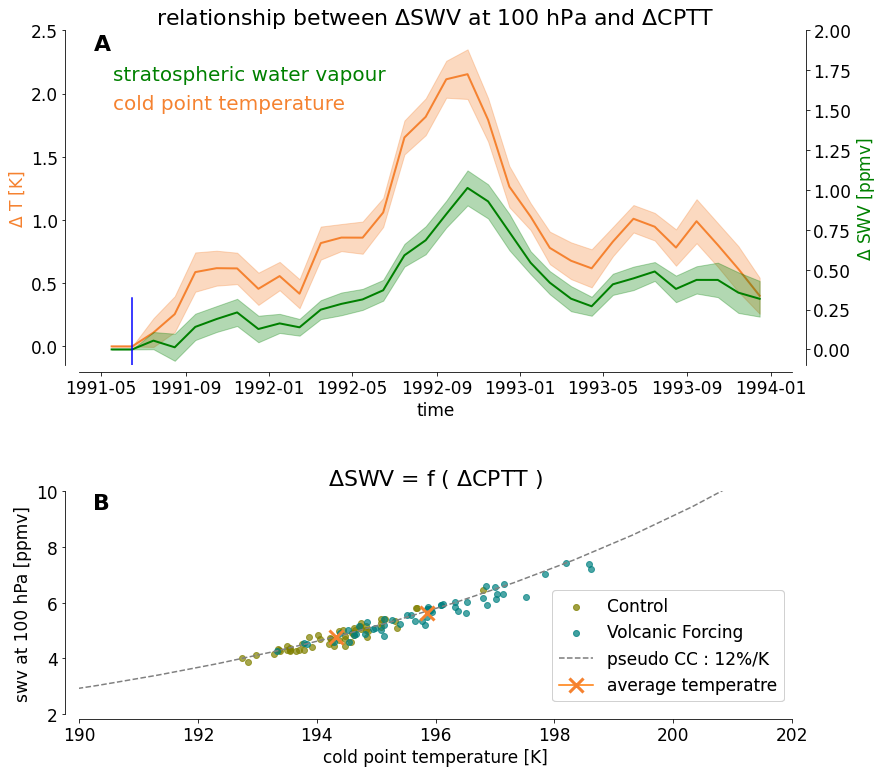

In [4]:
# %%
#####################################################################################################################
from matplotlib import gridspec
fig = plt.figure(figsize = [5,5])
gs = gridspec.GridSpec(2, 1, height_ratios=[1.5, 1]) 
plt.subplots_adjust(bottom=0, left=.01, right=1.99, top=1.90, hspace=.45)
# plot 1
ax1 = plt.subplot(gs[0])
# fig.autofmt_xdate()
ax1.plot(niceDates[4:],deltaT[4:],color=colors['orange'],linewidth=2.0)
ax1.fill_between(niceDates[4:],  (deltaT[4:]+errorT[4:]), (deltaT[4:]-errorT[4:]),alpha=0.3,color=colors['orange'])        
# ax1.set_title('differences in cold point temperature',fontsize=titlesizes)
ax1.set_ylabel('$\Delta$ T [K]',color=colors['orange'])#,fontsize=labelsizes)
ax1.set_xlabel('time')#,fontsize=labelsizes)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_position(('axes',-0.02))
ax1.yaxis.set_ticks_position('left')
ax1.spines['left'].set_position(('axes',-0.02))
ax1.tick_params(axis='x', direction='out')
ax1.tick_params(axis='y', direction='out')
ax1.set_ylim([-0.15,2.5])

#############################################for sub-classes##########################################
ax2 = fig.add_subplot(211,sharex=ax1,frameon=False)
ax2.plot(niceDates[4:],deltaQ[4:]*factorQ,color=colors['green'],linewidth=2.0)
ax2.fill_between(niceDates[4:],  (deltaQ[4:]+errorQ[4:])*factorQ, (deltaQ[4:]-errorQ[4:])*factorQ,alpha=0.3,color=colors['green'])        
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.set_ylabel('$\Delta$ SWV [ppmv]',color=colors['green'])#,fontsize=labelsizes)
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(True)
ax1.spines['right'].set_position(('axes', 1.02))
ax2.spines['right'].set_position(('axes', 1.02))
ax2.set_ylim([-0.1,2])


##########################################for plotting legend###################################
ax2.plot(niceDates[4:],deltaQ[4:]*factorQ,label='stratospheric water vapour',color=colors['green'],linewidth=0)
ax2.plot(niceDates[4:],deltaT[4:],label='cold point temperature',color=colors['orange'],linewidth=0)
leg = plt.legend(loc='upper left', bbox_to_anchor=(0.0,0.95), fontsize=20, handlelength=0, markerscale=0, frameon=False)
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())

#########################################################################
ax2.axvline(x=datetime.date(1991,6,15),ymin=-0.2,ymax=0.2,color='blue',label='volcanic eruption')
# fig = plt.figure(figsize = [5,2])
# plt.subplots_adjust(bottom=0, left=.01, right=1.99, top=1.90, hspace=.45)
ax3 = fig.add_subplot(gs[1])
# ax.set_title('OND 1992',fontsize=titlesizes)

lo=ax3.scatter(cptt[:,begin:end],cpQ[:,begin:end],color=colors['olive'],label='Control',alpha=0.7)
bp=ax3.scatter(cptt_vol[:,begin:end],cpQ_vol[:,begin:end],color=colors['teal'],label='Volcanic Forcing',alpha=0.7)
# ax.errorbar(Tmeans,satPPMMCi,0.5*np.ones([np.shape(Tmeans)[0]]),marker='x',markersize='13',label='PPMV ice \n (Murphy)',linestyle='--',color='orange')
ll=ax3.plot(CCtarray,CC, linestyle='--',color='grey',label='pseudo CC \n 12%/K')

mark=ax3.plot(np.mean(cptt[:,begin:end]),np.mean(cpQ[:,begin:end]),marker="x", markeredgecolor=colors['orange'], markersize=14, mew=3)#,markersize='18',color='orange',markeredgewidth=2)
mark=ax3.plot(np.mean(cptt_vol[:,begin:end]),np.mean(cpQ_vol[:,begin:end]),marker="x", markeredgecolor=colors['orange'], markersize=14, mew=3)#,markersize='18',color='orange',markeredgewidth=2)
# ax.scatter(np.mean(cptt[:,begin:end]), np.mean(cpQ[:,begin:end]), c="orange", s=100, marker="X", linewidth=1)
ax3.set_xlim(xlims[0], xlims[1])
ax3.set_ylim(ylims[0],ylims[1])
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_position(('axes',-0.02))
ax3.spines['left'].set_position(('axes',-0.02))
# ax.yaxis.grid(True)
ax3.tick_params(axis='both', which='major')
ax3.set_xlabel('cold point temperature [K]')
ax3.set_ylabel('swv at 100 hPa [ppmv]')

leg = ax3.legend([lo,bp,ll[0],mark[0]],
                 ['Control','Volcanic Forcing','pseudo CC : 12%/K','average temperatre'],
                 scatterpoints=1,
                 loc='lower right',
                 fontsize=17, bbox_to_anchor=(1,0.02))#, fontsize=17, handlelength=0, markerscale=0, frameon=False)
# for line, text in zip(leg.get_label, leg.get_texts()):
#     text.set_color(line.get_color())
ax3.add_artist(leg)

ax1.set_title('relationship between $\Delta$SWV at 100 hPa and $\Delta$CPTT')#,loc='left', x=-0.12,y=1.06)
ax3.set_title('$\Delta$SWV = f ( $\Delta$CPTT )')#,loc='left', x=-0.12,y=1.1)

# Label A ,B
for ax, label in zip([ax1,ax3],['A', 'B']):
    ax.text(0.02, 0.99, label, transform=ax.transAxes,
            fontsize=22, fontweight='bold', va='top')
    
fig.savefig('Figure2.png',bbox_inches='tight',dpi=300)